In [14]:
from dotenv import load_dotenv
import os
import sys
from pathlib import Path
project_root = Path().resolve().parent.parent  
sys.path.append(str(project_root))

from IPython.display import Image, display

In [15]:
from langgraph.graph import StateGraph, START, END

from backend.model.states.GraphState import GraphState
from backend.nodes.get_summary_node import get_summary_node
from backend.nodes.chat_agent import chat_agent
from backend.pipeline.qa_tool.get_pdf_ready_pipeline import get_pdf_ready_pipeline
from backend.pipeline.summary_tool.process_check_router import process_check_router


def build_summary_graph(state:GraphState):

    graph = StateGraph(GraphState)

    graph.add_node("process_check_router", lambda state: state)
    graph.add_node("get_pdf_ready_pipeline", get_pdf_ready_pipeline)
    graph.add_node("get_summary_node", get_summary_node)
    graph.add_node("chat_agent", chat_agent)

    graph.add_edge(START, "process_check_router")
    graph.add_edge("process_check_router", "get_pdf_ready_pipeline")
    graph.add_edge("get_pdf_ready_pipeline", "get_summary_node")
    graph.add_edge("get_summary_node","chat_agent")

    graph.add_conditional_edges(
        "process_check_router",
        process_check_router,
        {
            "FALSE": "get_pdf_ready_pipeline",
            "TRUE": "get_summary_node",
        },
    )

    graph.set_entry_point("process_check_router")
    graph.set_finish_point("chat_agent")

    app= graph.compile()
    display(Image(app.get_graph().draw_mermaid_png()))

    return app


2025-10-05 16:25:06.435 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


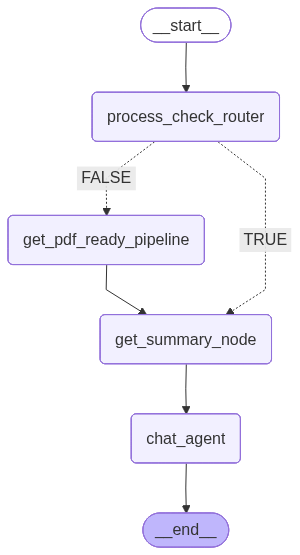

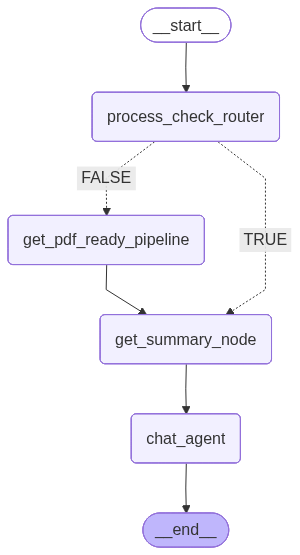

In [16]:
load_dotenv()
PDF_PATH = os.getenv("PDF_PATH")
PDF_NAME = os.getenv("PDF_NAME")


state = GraphState()
state.qa_state.pdf_path = PDF_PATH
build_summary_graph(state)